# QAOA for solving MaxCut problem

In [1]:
!pip install qiskit

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize

In [6]:
backend = Aer.get_backend('qasm_simulator')

## 5-vertices graph

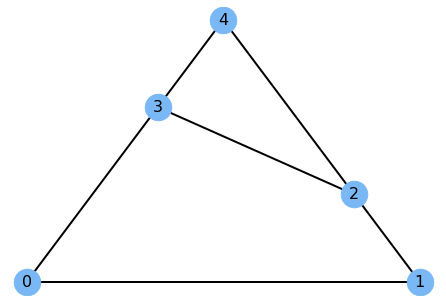

In [7]:
G = nx.Graph()
G.add_edges_from([[0, 1], [1, 2], [0, 3], [2, 3], [3, 4], [2, 4]])
nx.draw(G, with_labels = True, node_color='#7ab8f5', width=2, font_size=16, node_size=700, pos=nx.planar_layout(G))

In [8]:
def C_operator_gates(G, alpha):
    n = G.number_of_nodes()
    qc = QuantumCircuit(n,n)
    
    for i, j in G.edges():
            qc.cx(i, j)
            qc.rz(alpha * 2, j)
            qc.cx(i, j)
            
    return qc

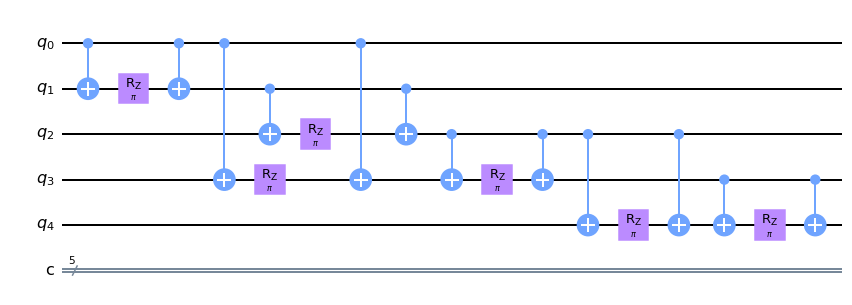

In [9]:
qc = C_operator_gates(G, np.pi / 2)
qc.draw()

In [10]:
def B_operator_gates(G, beta):
    n = G.number_of_nodes()
    qc = QuantumCircuit(n,n)
    
    for node in G.nodes():
        qc.rx(2*beta, node)
        
    return qc


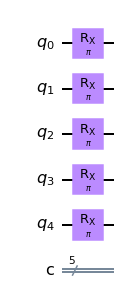

In [11]:
qc = B_operator_gates(G, np.pi/2)
qc.draw()

In [12]:
def create_full_circuit(G, alpha, beta):
    n = G.number_of_nodes()
    qc = QuantumCircuit(n,n)

    qc.h(range(n))
    
    qc += C_operator_gates(G, alpha)
    qc += B_operator_gates(G, beta)
    
    qc.barrier(range(n))
    qc.measure(range(n), range(n))
    
    return qc

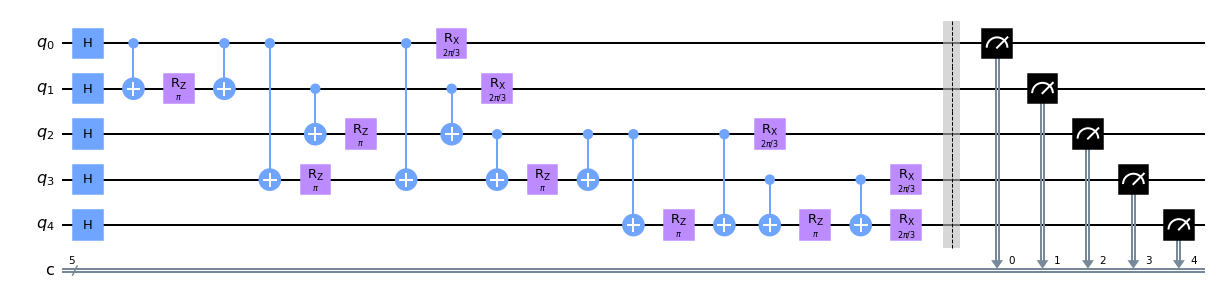

In [13]:
qc_5 = create_full_circuit(G, np.pi/2, np.pi/3)
qc_5.draw()

In [15]:
# helper function to change the orfer of bits returned from Qiskit
def change_order_of_bits(frequencies):
    return {state[::-1]:frequencies for state, frequencies in frequencies.items()}

Distribution of states before optimization


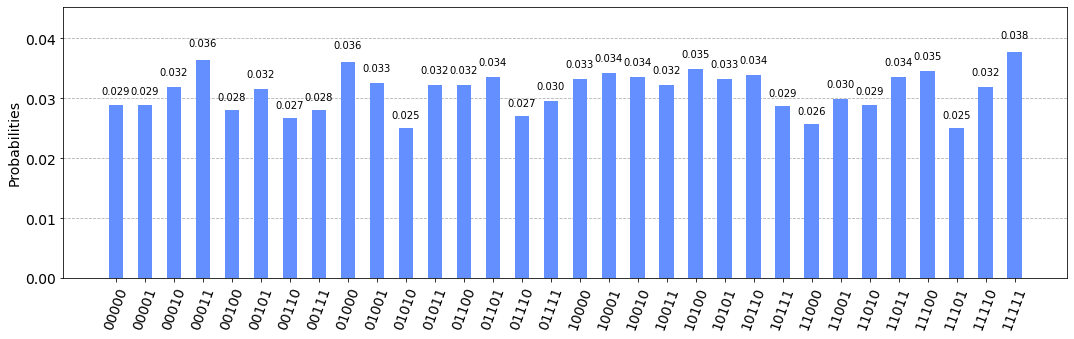

In [18]:
job = execute(qc_5, backend, shots = 3072)
frequencies = change_order_of_bits(job.result().get_counts())
plot_histogram(frequencies, figsize=(18, 5))

In [19]:
def get_cut_size_from_state_string(G, state):
    cut = 0
    
    for i, j in G.edges():
        if state[i] != state[j]:
            cut += 1
    return cut

In [20]:
def get_average_energy(G, frequencies):
    total_energy = 0
    total_frequencies = 0
    
    for state, frequence in frequencies.items():
        total_energy -= get_cut_size_from_state_string(G, state) * frequence
        total_frequencies += frequence
    avg_energy = total_energy / total_frequencies
    
    return avg_energy

In [21]:
def get_most_frequent_state(frequencies):
    state =  max(frequencies, key=lambda x: frequencies[x])
    
    return state

In [22]:
def get_exact_maxcut(G, frequencies):
    states = [(get_cut_size_from_state_string(G, state), state) for state in frequencies.keys()]
    maxcut, maxcut_state = max(states, key = lambda x: x[0])
    
    return maxcut, maxcut_state

In [23]:
def get_cost_function(G):
    def cost_function(theta):
        alpha = theta[1:]
        beta = theta[:1]
        
        qc = create_full_circuit(G, alpha, beta)
        frequencies = execute(qc, backend, shots=3072, seed_simulator=7).result().get_counts()

        return get_average_energy(G, change_order_of_bits(frequencies))
    return cost_function

In [24]:
def minimize_cost_function(G, init_point):
    cost = get_cost_function(G)
    np_init_point = np.array(init_point)
    result = minimize(cost, np_init_point, method='COBYLA', options={'maxiter':3500, 'disp': True})
    return result

In [25]:
def get_frequencies_for_optimal_cirquit(G, minimization_result):
    params = minimization_result['x']
    qc = create_full_circuit(G, params[1:], params[:1])
    frequencies = change_order_of_bits(execute(qc, backend, shots=20000).result().get_counts())
    
    return frequencies

In [26]:
result = minimize_cost_function(G, [0.84729, 2.60322])
result

     fun: -4.089192708333333
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 33
  status: 1
 success: True
       x: array([1.90635692, 2.82098742])

Distribution of states after optimization

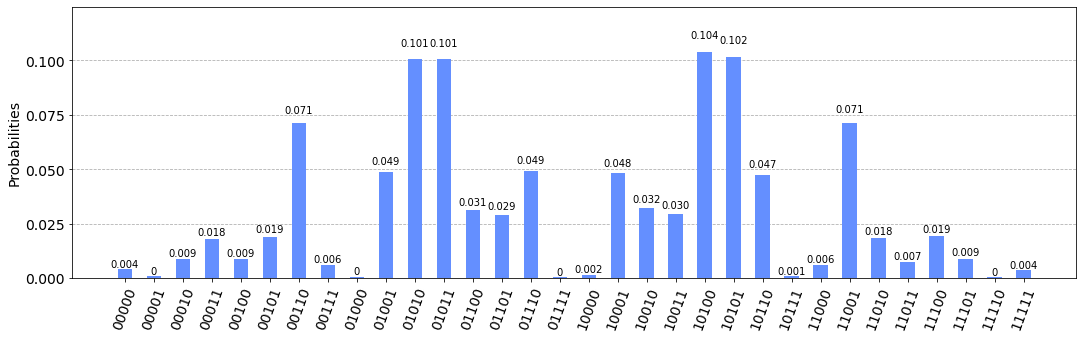

In [31]:
frequencies = get_frequencies_for_optimal_cirquit(G, result)

plot_histogram(frequencies, figsize=(18, 5))

In [38]:
maxcut_state = get_most_frequent_state(frequencies);
maxcut_cut = get_cut_size_from_state_string(G, maxcut_state)
print('QAOA best solution:', maxcut_state, 'with cut size', maxcut_cut)
print('Exact max cut size:', get_exact_maxcut(G, frequencies)[0])
print('Average cut size from all executions: ', -get_average_energy(G, frequencies))

QAOA best solution: 10100 with cut size 5
Exact max cut size: 5
Average cut size from all executions:  4.1101


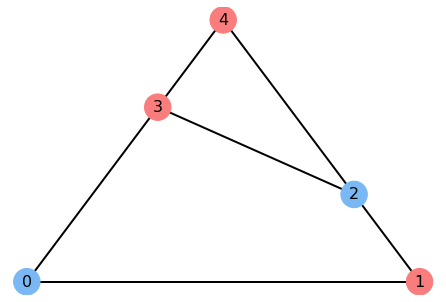

In [39]:
colors = ['#7ab8f5' if maxcut_state[node] == '1' else '#fa7d7d' for node in G]
nx.draw(G, with_labels = True, node_color=colors, width=2, font_size=16, node_size=700, pos=nx.planar_layout(G))

## 10-vertices graph

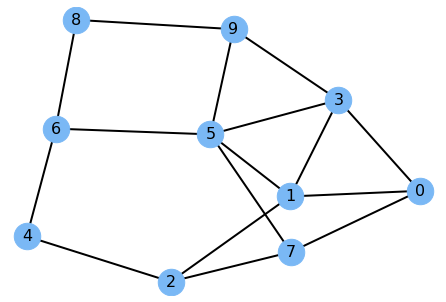

In [40]:
G = nx.Graph()
G.add_edges_from([[0, 1], [6, 8], [9, 8], [9, 5], [1, 2], [9, 3], [0, 3], [2, 4], [1, 3], [3, 5], [1,5], [5, 3], [6,5], [4,6], [7, 2], [7,5], [7, 0]])
nx.draw(G, with_labels = True, node_color='#7ab8f5', width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

In [41]:
result = minimize_cost_function(G, [2.647339, 3.90922])
frequencies = get_frequencies_for_optimal_cirquit(G, result)
result

     fun: -10.557291666666666
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 36
  status: 1
 success: True
       x: array([2.79231024, 3.44081268])

In [42]:
maxcut_state = get_most_frequent_state(frequencies);
maxcut_cut = get_cut_size_from_state_string(G, maxcut_state)
print('QAOA best solution:', maxcut_state, 'with cut size', maxcut_cut)
print('Exact max cut size:', get_exact_maxcut(G, frequencies)[0])
print('Average cut size from all executions: ', -get_average_energy(G, frequencies))

QAOA best solution: 0101100110 with cut size 13
Exact max cut size: 13
Average cut size from all executions:  10.55285


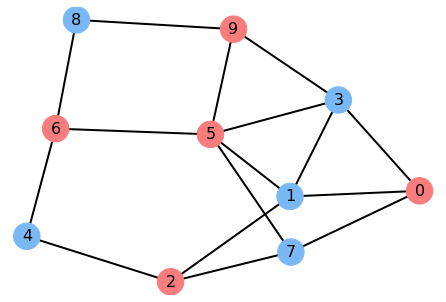

In [43]:
colors = ['#7ab8f5' if maxcut_state[node] == '1' else '#fa7d7d' for node in G]
nx.draw(G, with_labels = True, node_color=colors, width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

## 20-vertices graph

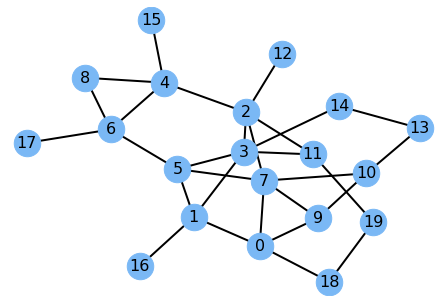

In [64]:
G = nx.Graph()
G.add_edges_from([[0, 1], [12, 2], [13, 10], [14, 13], [15, 4], [16, 1], [17, 6], [18, 0], [19, 18], [6, 8], [8, 4], [9, 7], [9, 0], [10, 9], [11,3], [11, 19], [10, 7], [11, 2], [2, 3], [14, 3], [2, 4], [1, 3], [3, 5], [1,5], [5, 3], [6,5], [4,6], [7, 2], [7,5], [7, 0]])
nx.draw(G, with_labels = True, node_color='#7ab8f5', width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

In [101]:
result = minimize_cost_function(G, [1.656452, 3.33238])
frequencies = get_frequencies_for_optimal_cirquit(G, result)
result

     fun: -19.152994791666668
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 37
  status: 1
 success: True
       x: array([2.77771133, 3.45212969])

In [102]:
maxcut_state = get_most_frequent_state(frequencies);
maxcut_cut = get_cut_size_from_state_string(G, maxcut_state)
print('QAOA best solution:', maxcut_state, 'with cut size', maxcut_cut)
print('Exact max cut size:', get_exact_maxcut(G, frequencies)[0])
print('Average cut size from all executions: ', -get_average_energy(G, frequencies))

QAOA best solution: 01011011010111000010 with cut size 25
Exact max cut size: 25
Average cut size from all executions:  19.10555


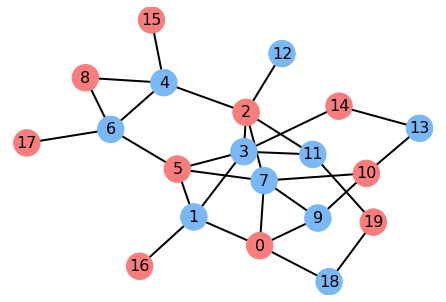

In [103]:
colors = ['#7ab8f5' if maxcut_state[node] == '1' else '#fa7d7d' for node in G]
nx.draw(G, with_labels = True, node_color=colors, width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

## 25-vertices graph


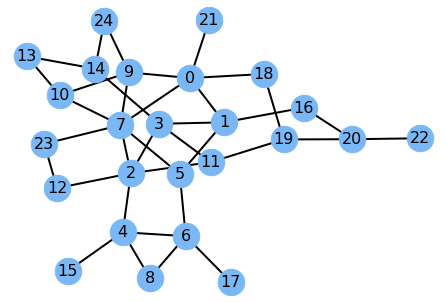

In [104]:
G = nx.Graph()
G.add_edges_from([[19,20], [20,16], [21,0], [22, 20], [23,12], [24, 14], [24,9], [0, 1], [12, 2], [13, 10], [14, 13], [15, 4], [16, 1], [17, 6], [18, 0], [19, 18], [6, 8], [8, 4], [9, 7],[7,23], [9, 0], [10, 9], [11,3], [11, 19], [10, 7], [11, 2], [2, 3], [14, 3], [2, 4], [1, 3], [1,5], [6,5], [4,6], [7, 2], [7,5], [7, 0]])
nx.draw(G, with_labels = True, node_color='#7ab8f5', width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

In [111]:
result = minimize_cost_function(G, [1.57082, 2.83617])
frequencies = get_frequencies_for_optimal_cirquit(G, result)
result

     fun: -24.083984375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 32
  status: 1
 success: True
       x: array([0.39134924, 2.83948633])

In [112]:
maxcut_state = get_most_frequent_state(frequencies);
maxcut_cut = get_cut_size_from_state_string(G, maxcut_state)
print('QAOA best solution:', maxcut_state, 'with cut size', maxcut_cut)
print('Exact max cut size:', get_exact_maxcut(G, frequencies)[0])
print('Average cut size from all executions: ', -get_average_energy(G, frequencies))

QAOA best solution: 1011010010100101110100111 with cut size 32
Exact max cut size: 32
Average cut size from all executions:  24.0598


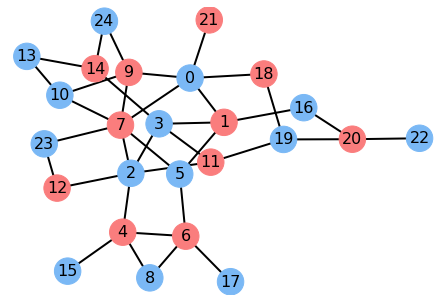

In [113]:
colors = ['#7ab8f5' if maxcut_state[node] == '1' else '#fa7d7d' for node in G]
nx.draw(G, with_labels = True, node_color=colors, width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))